# Co-occurrence Analysis

Cognitive Control has many faces and a good part of cognitive literature targets the "Control" using multiple tests. On that note, the co-occurrences of tasks and constructs in the literature help us identify tests that are commonly used together, tests that are validated by other tests, and tests that can be ignored due to redundancy or lack of correlation with other standard tests. This co-occurrence analysis improves our understanding of the coverage and dependencies in the Cognitive Control tests.

This notebooks demonstrates analyses of co-occurrences of cognitive tests in PubMed articles.

 # Labels Co-occurrence Matrix

 This notebook generates a matrix that contains task/construct co-occurrence frequencies. Values indicate number of articles that both the task and the construct were mentioned in.

## Output

Co-occurrence matrix ($X_{\text{COOC}}$) is stored as sparse format in the `data/pubmed/pubmed/cooc.csv` path with the following columns in it:

 - `construct`: Name of the cognitive construct.
 - `task`: Name of the cognitive task (a.k.a. subcategory or label).
 - `task_corpus_size`: Number of articles in the cognitive task corpus.
 - `construct_corpus_size`: Number of articles in the cognitive construct corpus.
 - `union_corpus_size`: Total number of unique articles in either of the two corpora.
 - `intersection_corpus_size`: Number of articles that are shared in the two corpora.
 - `jaccard_coefficient`: $\text{intersection} \over \text{union}$


In [3]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # noqa
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

import networkx as nx

from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext import co_occurrence_matrix, svd_embedding
from python.cogtext import plotting

In [8]:
# Parameters


data_loader = PubMedDataLoader(drop_low_occurred_labels=True)
data = data_loader()
"""Path to the pubmed abstracts dataset."""

JACCARD_COEF_THRESHOLD = 0.001
"""Discard all the values below this threshold."""

COOC_LONG_DF = data.pipe(co_occurrence_matrix, jaccard_coefficient=True, groupby_category=True)

In [10]:
# load the COOC matrix
cooc = COOC_LONG_DF.pivot(index='construct', columns='task', values='jaccard_coefficient')

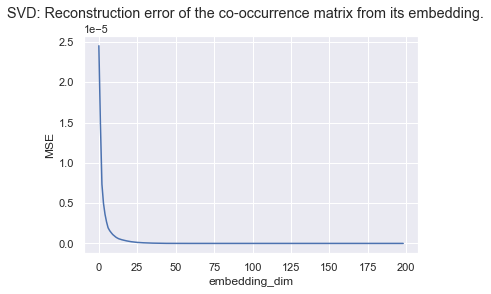

In [14]:
recon_loss = [mean_squared_error(cooc, svd_embedding(cooc, k)[3]) for k in range(1, 200)]
plt.plot(recon_loss)
plt.xlabel('embedding_dim')
plt.ylabel('MSE')
plt.suptitle('SVD: Reconstruction error of the co-occurrence matrix from its embedding.')
plt.show()

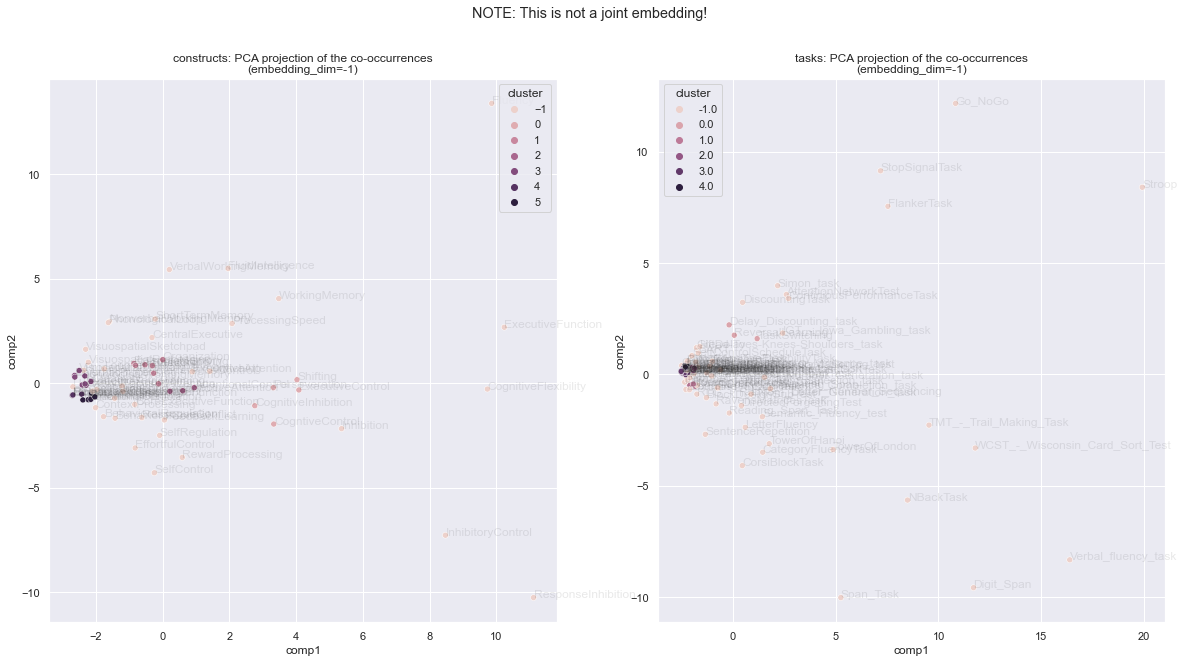

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


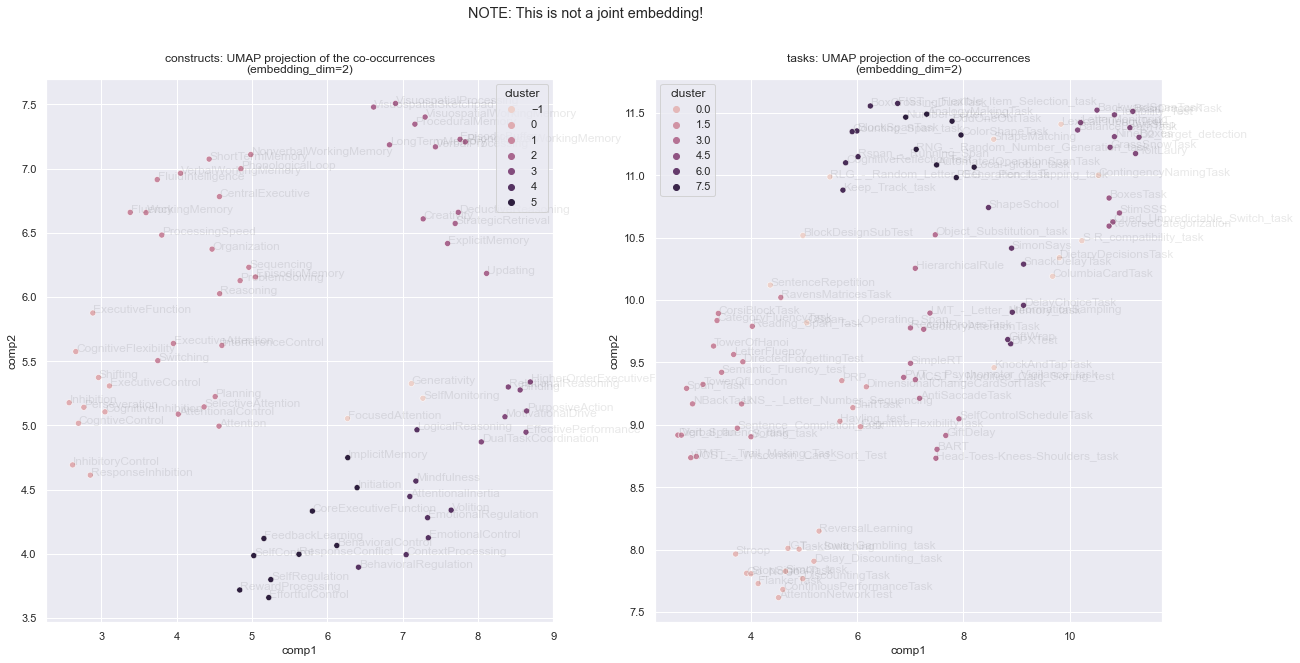

In [15]:

# PCA (no embedding compression)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plotting.plot_cooc_projection(cooc, kind='pca', title='constructs', ax=axes[0])
plotting.plot_cooc_projection(cooc.T, kind='pca', title='tasks', ax=axes[1])
plt.suptitle('NOTE: This is not a joint embedding!')
plt.show()

# UMAP (2D embedding)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plotting.plot_cooc_projection(cooc, 2, kind='umap', title='constructs', ax=axes[0])
plotting.plot_cooc_projection(cooc.T, 2, kind='umap', title='tasks', ax=axes[1])
plt.suptitle('NOTE: This is not a joint embedding!')
plt.show()


Let's plot a simple heatmap in that cells show the co-occurrence of tasks and constructs.

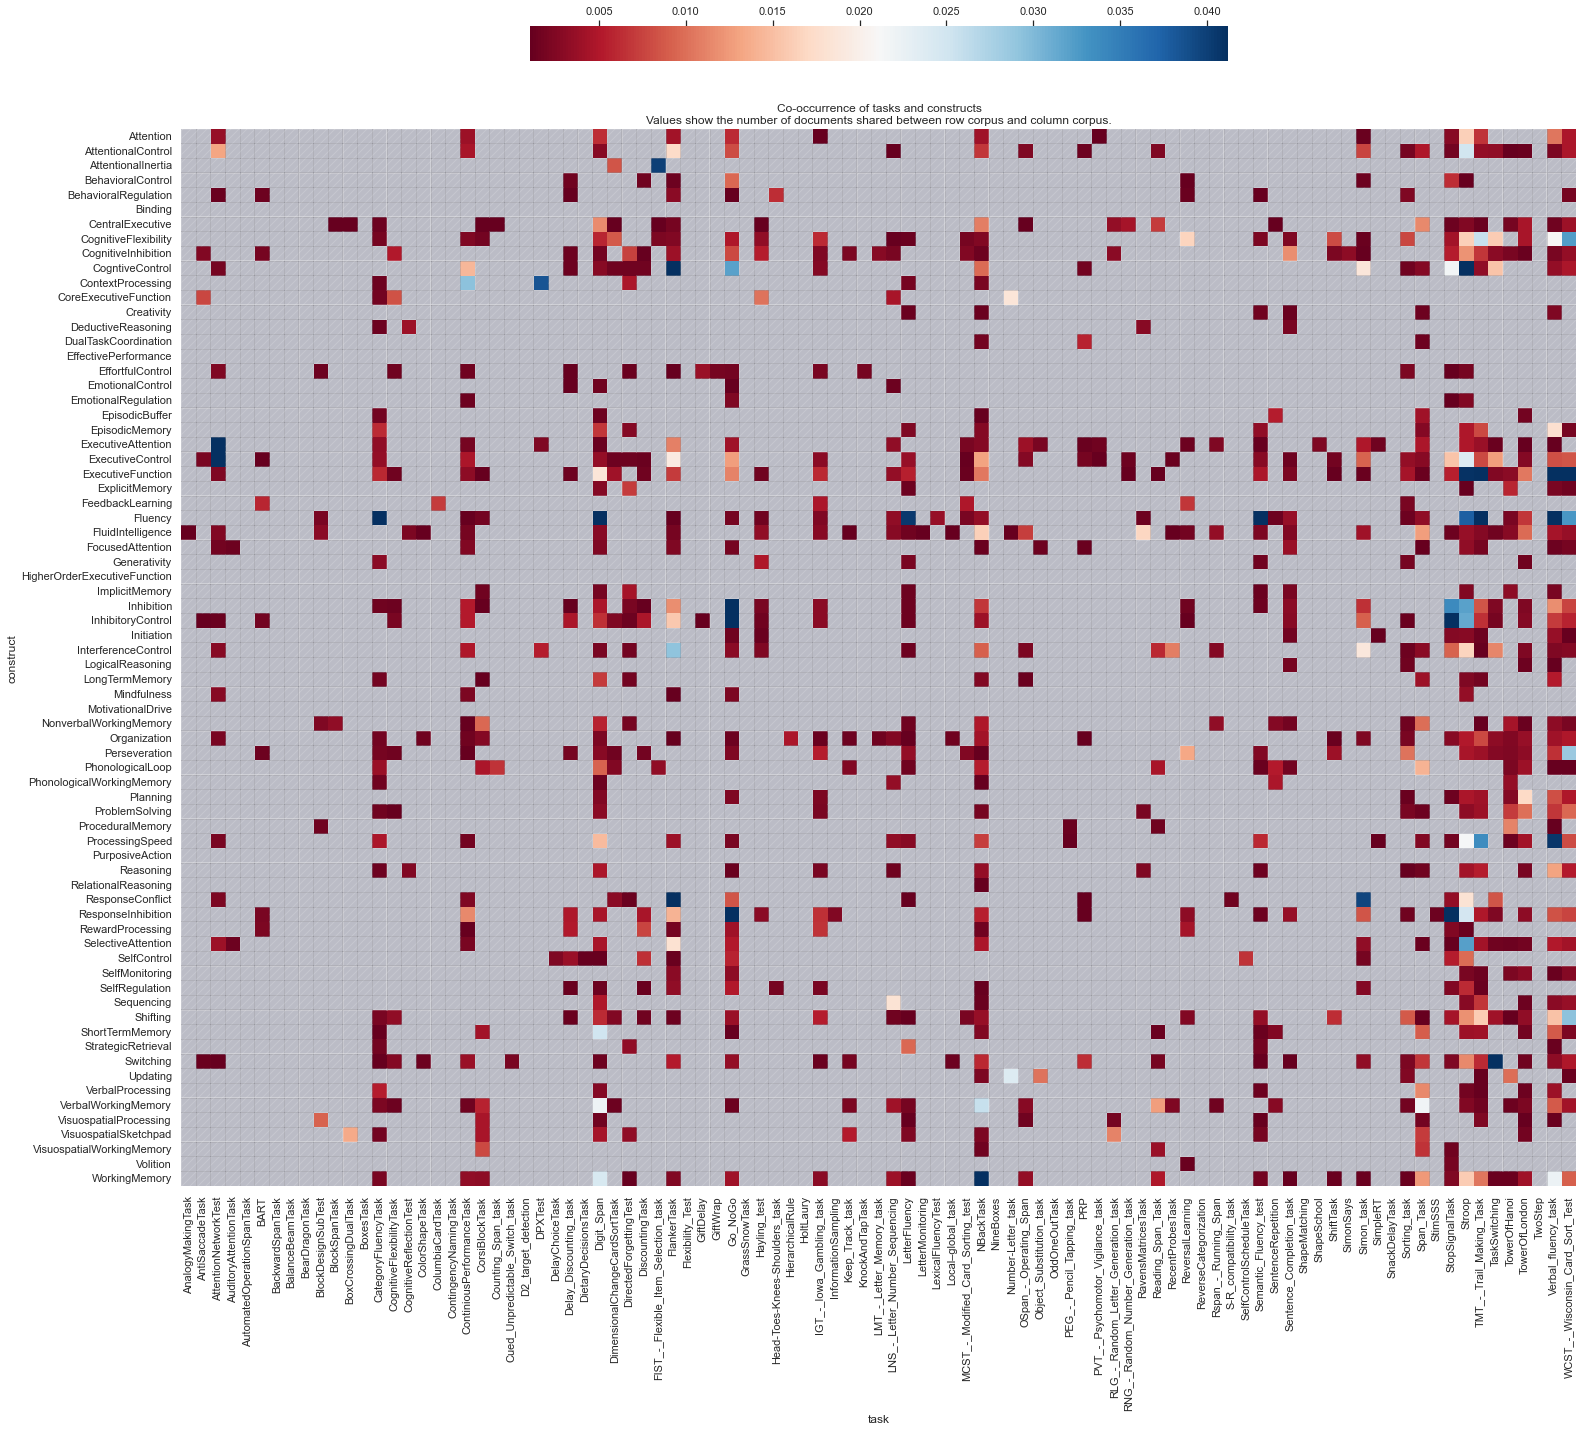

In [17]:
_, ax = plt.subplots(1,1,figsize=(25,25))

sns.heatmap(
  cooc.applymap(lambda x: np.nan if x < JACCARD_COEF_THRESHOLD else x),
  cbar_kws = {'use_gridspec':False, 'location':'top', 'shrink': .5},
  square=True,
  robust=True,
  cmap='RdBu',
  ax=ax)

# plt.xticks(rotation=45, ha='right') 

ax.pcolor(
  cooc.applymap(lambda x: np.nan if x >= JACCARD_COEF_THRESHOLD else 0.).values,
  hatch='///', alpha=.2, color='whitesmoke', fc='whitesmoke')

ax.set(title=
    'Co-occurrence of tasks and constructs\n'
    'Values show the number of documents shared between row corpus and column corpus.')

plt.savefig('outputs/co_occurrences/heatmap.png')
plt.show()

Here is the same heatmap, but now values are clustered:

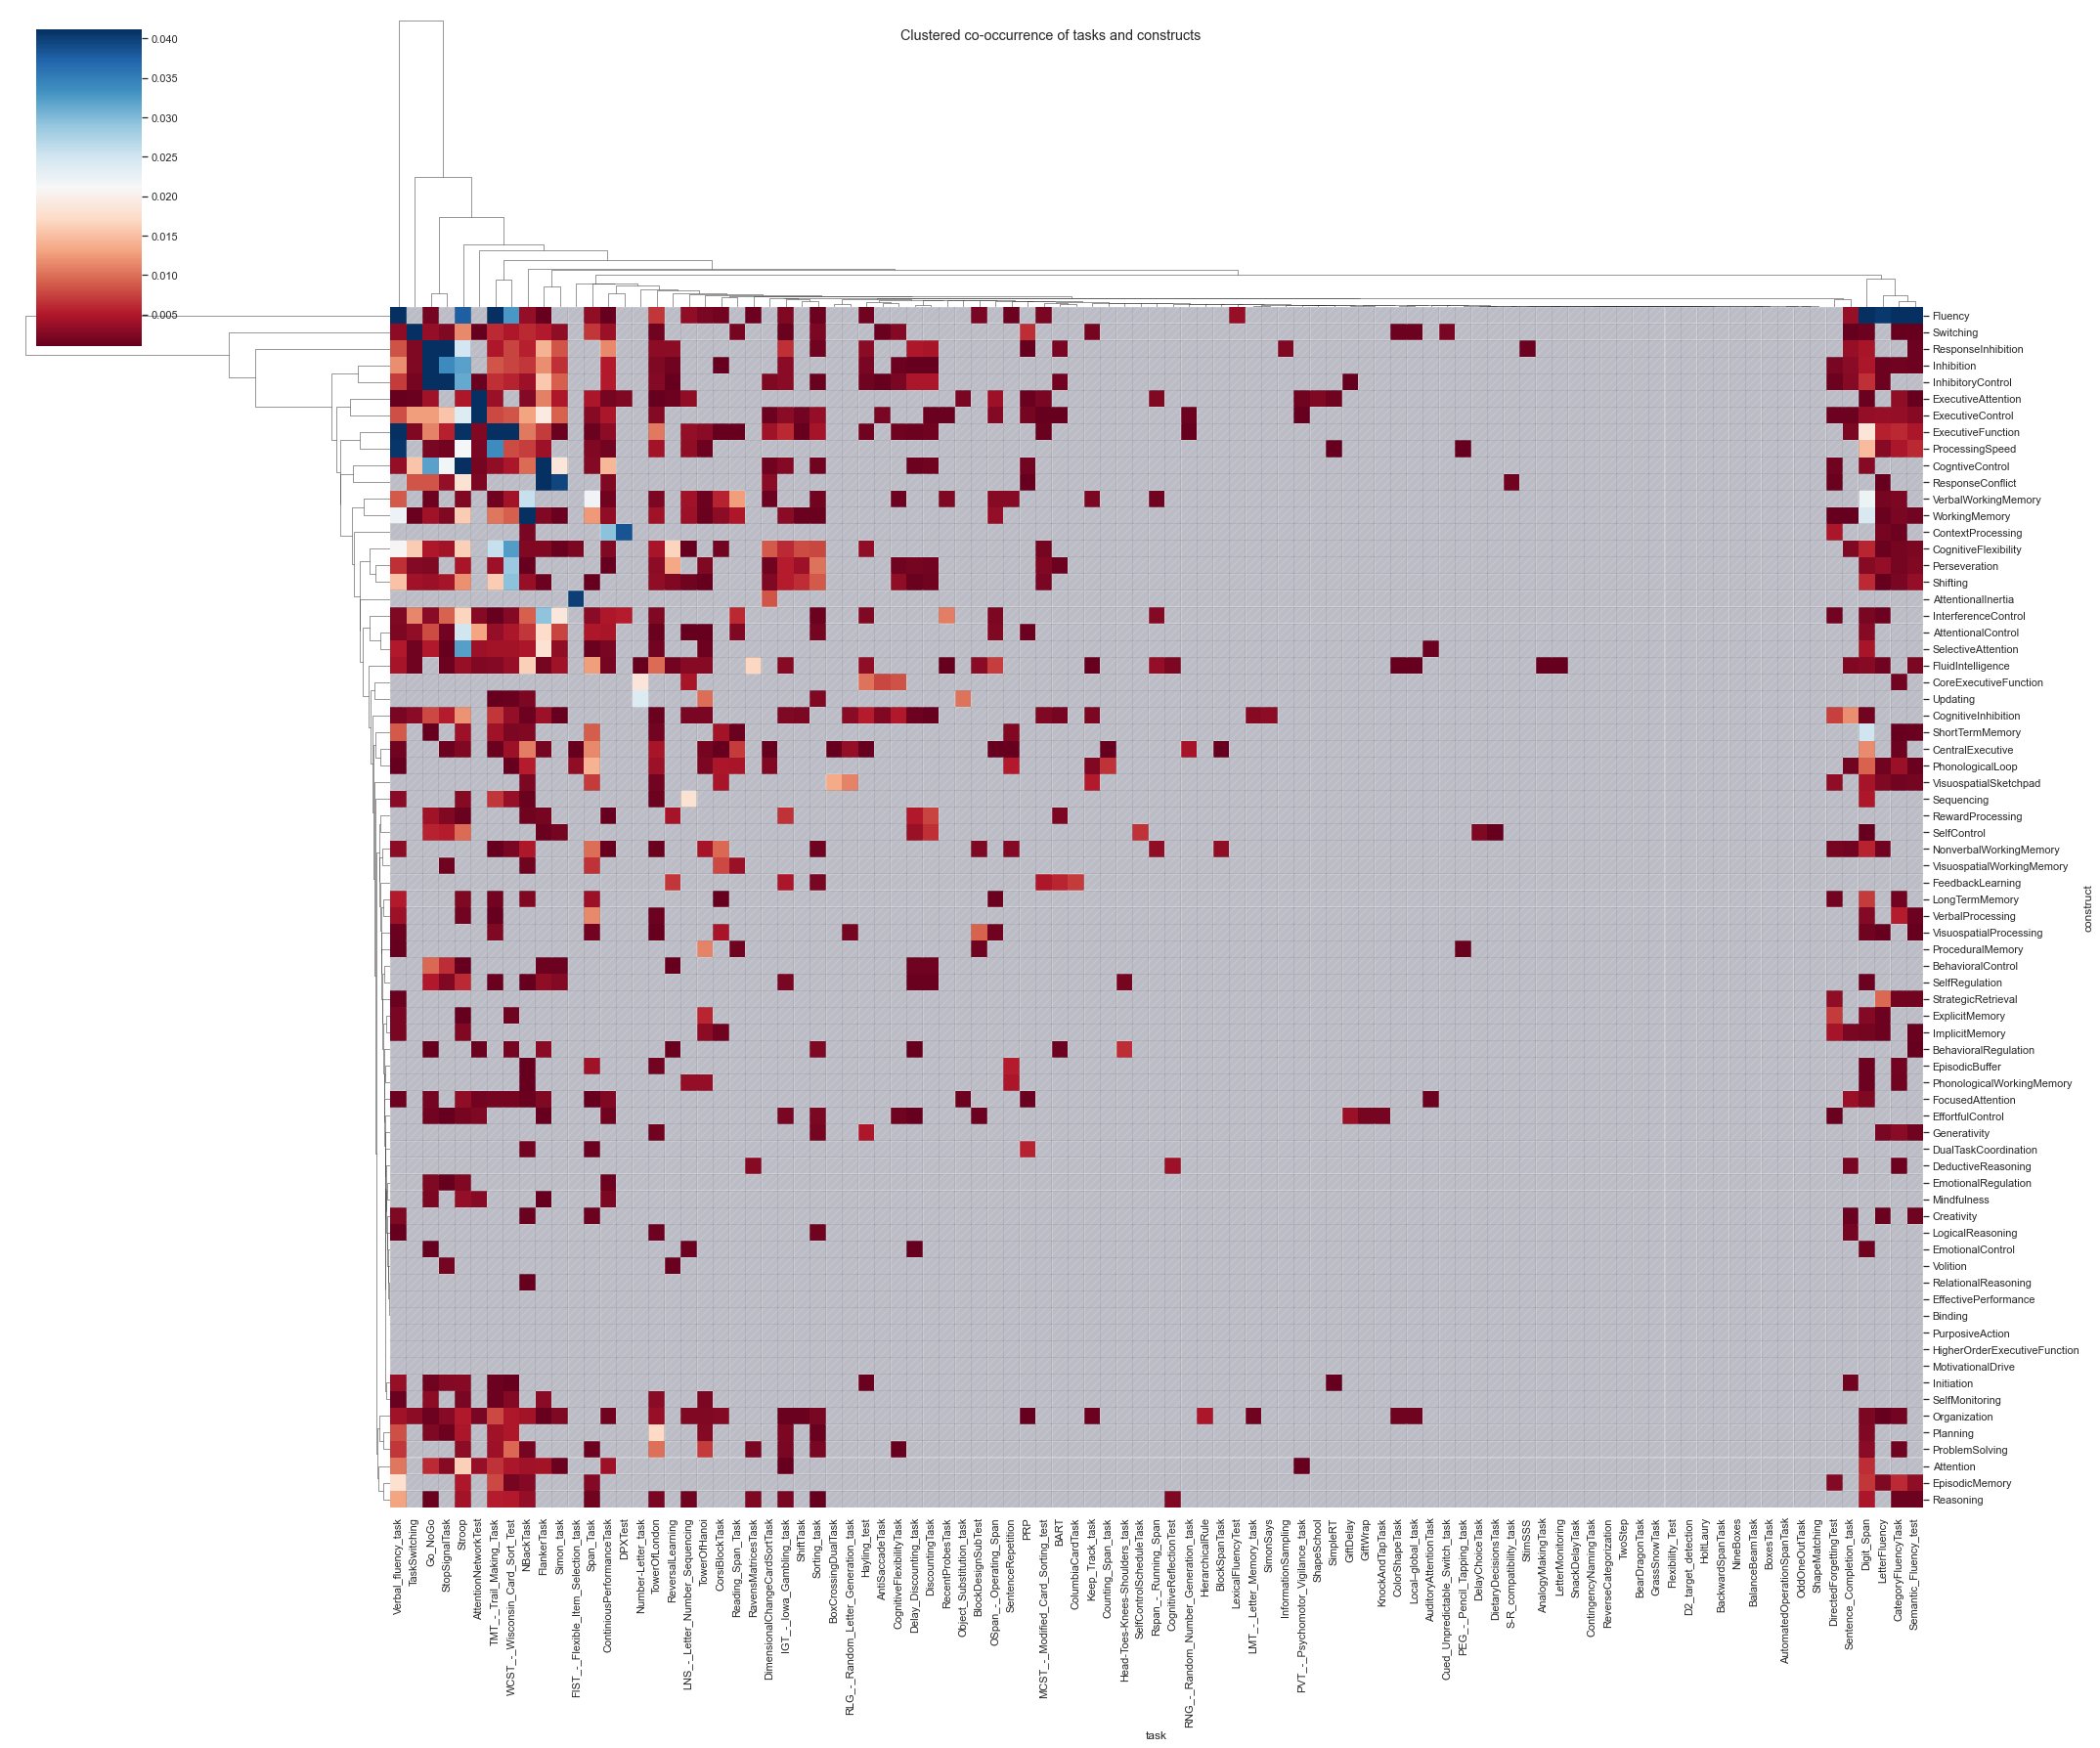

In [18]:
g = sns.clustermap(
  cooc,
  figsize=(30,25),
  cmap='RdBu',
  mask=cooc.applymap(lambda x: x < JACCARD_COEF_THRESHOLD ),
  robust=True,
  lw=0,
)

g.ax_heatmap.pcolor(
  g.data2d.applymap(lambda x: np.nan if x >= JACCARD_COEF_THRESHOLD else 0.),
  hatch='///', alpha=.2, color='whitesmoke', fc='whitesmoke'
)

plt.suptitle('Clustered co-occurrence of tasks and constructs')
plt.savefig('outputs/co_occurrences/clustermap.png')
plt.show()

## Visualization preprocessing 

Before plotting the co-occurrence map as a graph, some preprocessing steps significantly improve the visuals:

1. remove low degree nodes and low weight edges.
2. Use degree centrality as node sizes; degree centrality shows number of connected edges to a given nodes (both inputs and outputs). Another measure that can be used for node sizes is the number of non-co-occurred articles that only mentioned once in the related test corpus.
3. Find communities in the graph, that are highly connected subgraphs. This property can be used to layout the graph and colorize the nodes.
4. Put co-occurred tests closer to each other by using force-driven spring layout.

I will use the de-facto NetworkX package to perform all the graph analysis listed above. The output will be a bidirectional graph that encapsulates centrality of each node, communities, edge widths, and positioning layout.

- [ ] **TODO:** greedy modularity algorithm returns one community because nodes are densely connected. Use another algorithm to extract some information from the graph structure.

In [19]:
# rebuild the COOC matrix, this time without task/construct separation
COOC_CATEGORIZED_LONG_DF = data.pipe(
  co_occurrence_matrix, jaccard_coefficient=True, groupby_category=False)

cooc_categorized = COOC_CATEGORIZED_LONG_DF.pivot(
  index='label_1', columns='label_2', values='jaccard_coefficient')

In [21]:
# normalized co-occurrences below this threshold will be ignored
MIN_EDGE_WEIGHT = .001

# create graph from adjacency matrix
G = nx.from_numpy_matrix(cooc_categorized.values, create_using=nx.DiGraph)

G.remove_edges_from(nx.selfloop_edges(G))

# set node labels
node_labels = {i:t for i,t in enumerate(cooc_categorized.index)}
nx.set_node_attributes(G, node_labels, 'label')

# remove low weight edges and low degree nodes
low_weight_edges = [(u,v) for u, v in G.edges() if G[u][v]['weight'] < MIN_EDGE_WEIGHT]
G.remove_edges_from(low_weight_edges)

low_degree_nodes = [n for n, d in G.degree() if d == 0]
G.remove_nodes_from(low_degree_nodes)


print(f'[INFO] After removing {len(low_weight_edges)} low-weight edges, {len(G.edges())} remained.')
print(f'[INFO] The following low-degree nodes are removed:\n', '\n '.join([cooc_categorized.index[ldn] for ldn in low_degree_nodes]))


# Community detection

def heaviest(G):
    from operator import itemgetter
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u,v)

import itertools
n_communities = 10   # number of communities

all_comms = list(itertools.takewhile(
        lambda c: len(c) <= n_communities, nx.community.girvan_newman(G, most_valuable_edge=heaviest)
))

comms = all_comms[-1] if len(all_comms)>0 else []
community_index = {n: i for i, comm in enumerate(comms) for n in comm}
nx.set_node_attributes(G, community_index, 'community')


# compute centrality
centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'centrality')

# visual properties (all numeric values are relative, update them to match your canvas)
node_colors = list(community_index.values())
node_colors = [1 for i in community_index] # DEBUG
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]


# compute layout positions
pos = nx.spring_layout(G, k=.8)


[INFO] After removing 3684 low-weight edges, 4780 remained.
[INFO] The following low-degree nodes are removed:
 BalanceBeamTask
 Binding
 D2_target_detection
 HoltLaury
 NineBoxes
 PurposiveAction


# NetworkX plot (static)

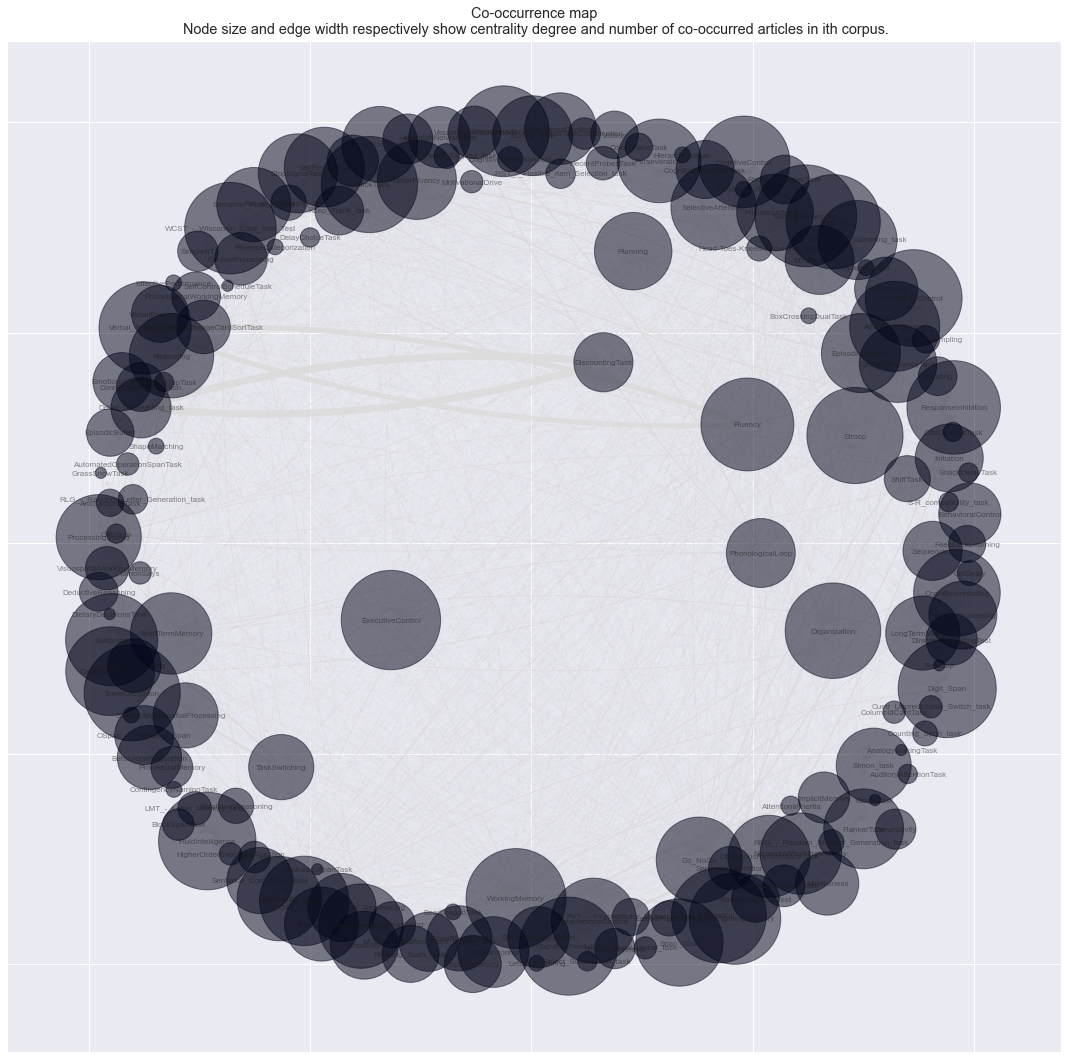

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=[max(10,v*10000) for v in centrality.values()],
                       alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=8, alpha=0.5, ax=ax)
# nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3, connectionstyle='arc3,rad=0.1')\n",
nx.draw_networkx_edges(G,
                       pos,
                       alpha=0.8,
                       arrowstyle='->',
                       arrowsize=10,
                       connectionstyle='arc3,rad=0.1',
                       width=[w*10 for w in  edge_widths],
                       edge_color='gainsboro',
                       ax=ax)

# plot the graph using matplotlib backend
plt.suptitle('Co-occurrence map\n Node size and edge width respectively show centrality degree and number of co-occurred articles in ith corpus.')
plt.tight_layout()
# plt.savefig('../outputs/co_occurrences/map_networkx.png')
# plt.close()
plt.show()

## Bokeh plot (interactive)

In [61]:

from bokeh.io import output_notebook, show; output_notebook()
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.plotting import from_networkx

plot = Plot(x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

graph_renderer = from_networkx(G, nx.spring_layout(G, k=5), scale=1, center=(0,0))

# data
graph_renderer.node_renderer.data_source.data['node_size'] = [max(10,v*50) for v in centrality.values()]
graph_renderer.edge_renderer.data_source.data['edge_size'] = [max(.1, v*20) for v in edge_widths]

# nodes
graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color='lightblue', line_color='white')
graph_renderer.node_renderer.selection_glyph = Circle(size='node_size', fill_color='mediumpurple', line_color='mediumpurple')
graph_renderer.node_renderer.nonselection_glyph = Circle(size='node_size', fill_color='lightblue', line_color='white')
graph_renderer.node_renderer.hover_glyph = Circle(size='node_size', fill_color='mediumpurple', line_color='mediumpurple')

# edges
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width='edge_size')
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color='mediumpurple', line_width='edge_size')
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color='mediumpurple', line_width='edge_size')

# tools
node_hover_tool = HoverTool(tooltips=[('Label','@label')])
plot.add_tools(node_hover_tool, TapTool())
graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

plot.title.text = "Interactive co-occurrence map of cognitive tests"
show(plot)

Loading BokehJS ...

## PyVis plot (interactive)

- [ ] **TODO:** bidirectional edges should be separated.

In [ ]:
from pyvis.network import Network

nt = Network(height='1000px', width='1000px', directed=False, notebook=True, heading='Co-occurrence Map')

nt.from_nx(G)

for i,n in enumerate(nt.nodes):
    n['size'] = max(10, n['centrality'] * 50)
    n['color'] = n['community']

for e in nt.edges:
    e['value'] = e['weight'] * 10



pyvis_options = """
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": 0,
      "centralGravity": 0,
      "springLength": 400,
      "springConstant": 0.1,
      "damping": 1,
      "avoidOverlap": 1
    }
  },
  "nodes": {
    "color": {
      "border": "white",
      "background": "lightblue",
      "highlight": {
        "border": "mediumpurple",
        "background": "mediumpurple"
      }
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      },
      "from": {
        "enabled": true
      }
    },
    "arrowStrikethrough": false,
    "color": {
      "color": "#dcdcdc88",
      "highlight": "mediumpurple",
      "inherit": false
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none"
    }
  }
}
"""

nt.set_options(pyvis_options)
# nt.show_buttons(filter_=['nodes'])

nt.show('outputs/co_occurrences/map_pyvis.html')

### Plotly Sankey (interactive)

**REQUIRES PLOTLY 5 OR NEWER**

There are two sankey plots, first showing number of shared articles, and then percent of shared articles (normalized by target corpus).

In [ ]:
import plotly.graph_objects as go

# comment to embed the plot into the notebook instead of opening the browser
import plotly.io as pio; pio.renderers.default = 'browser'

MIN_CO_OCCURRENCE = 0.01

# only pairs that appeared together at least 50 times
COOC_DF_2 = COOC_DF.query('jaccard_coefficient > @MIN_CO_OCCURRENCE')

sankey_nodes = dict(
      pad = 10,
      thickness = 10,
      line = dict(color = 'black', width = 0.5),
      label = COOC.index.tolist(),
      color = 'lightblue'
)

sankey_links = dict(
      source = COOC_DF_2['label_1'],
      target = COOC_DF_2['label_2'],
      value = COOC_DF_2['jaccard_coefficient']
)


fig = go.Figure(data=[go.Sankey(
    node = sankey_nodes,
    link = sankey_links
)])

fig.update_layout(
  title_text=f'Co-occurrence sankey map (only pairs that appeared together in at least '
             f'{MIN_CO_OCCURRENCE} articles of target corpus)',
  font_size=10)

fig.write_html('outputs/co_occurrences/sankey_map.html')

fig.show()
